In [1]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)

<module 'helper' from '../src\\helper.py'>

In [2]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/08_31_2020_identified_features_peak_areas_idx_b1-8.csv"
data = pd.read_csv(datafilename)

print(data.columns.values[:10])

#get area columns
areaCols = data.columns.values[5:]

#get molecule names
mol_names = data["Molecule Name"].values

#load in metadata
metadatafn = "../data/Experiment-Parameters_b1-8.csv"
metadata = pd.read_csv(metadatafn)
sampleNames = metadata["Sample General Name"].values

sampleNameDict = {}
for x in areaCols:
    temp = str(x)
    temp = temp.replace(" Area","")
    temp = temp.replace("_pns","")
    if "B3" in temp:
        for s in sampleNames:
            if temp in s:
                temp = s
                break
    if temp in sampleNames:
        sampleNameDict[x] = temp

        
print(len(sampleNameDict),len(sampleNames))

areaCols = [x for x in areaCols if x in sampleNameDict]

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)


['Molecule Name' 'Molecule Formula' 'Precursor Charge' 'Precursor Mz'
 'Explicit Retention Time' 'B1_pns_Blank_1 Area' 'B1_pns_Blank_2 Area'
 'B1_pns_Blank_3 Area' 'B1_pns_Blank_4 Area' 'B1_pns_Blank_5 Area']
616 616


144144


No handles with labels found to put in legend.


7208


Text(0, 0.5, 'PC2')

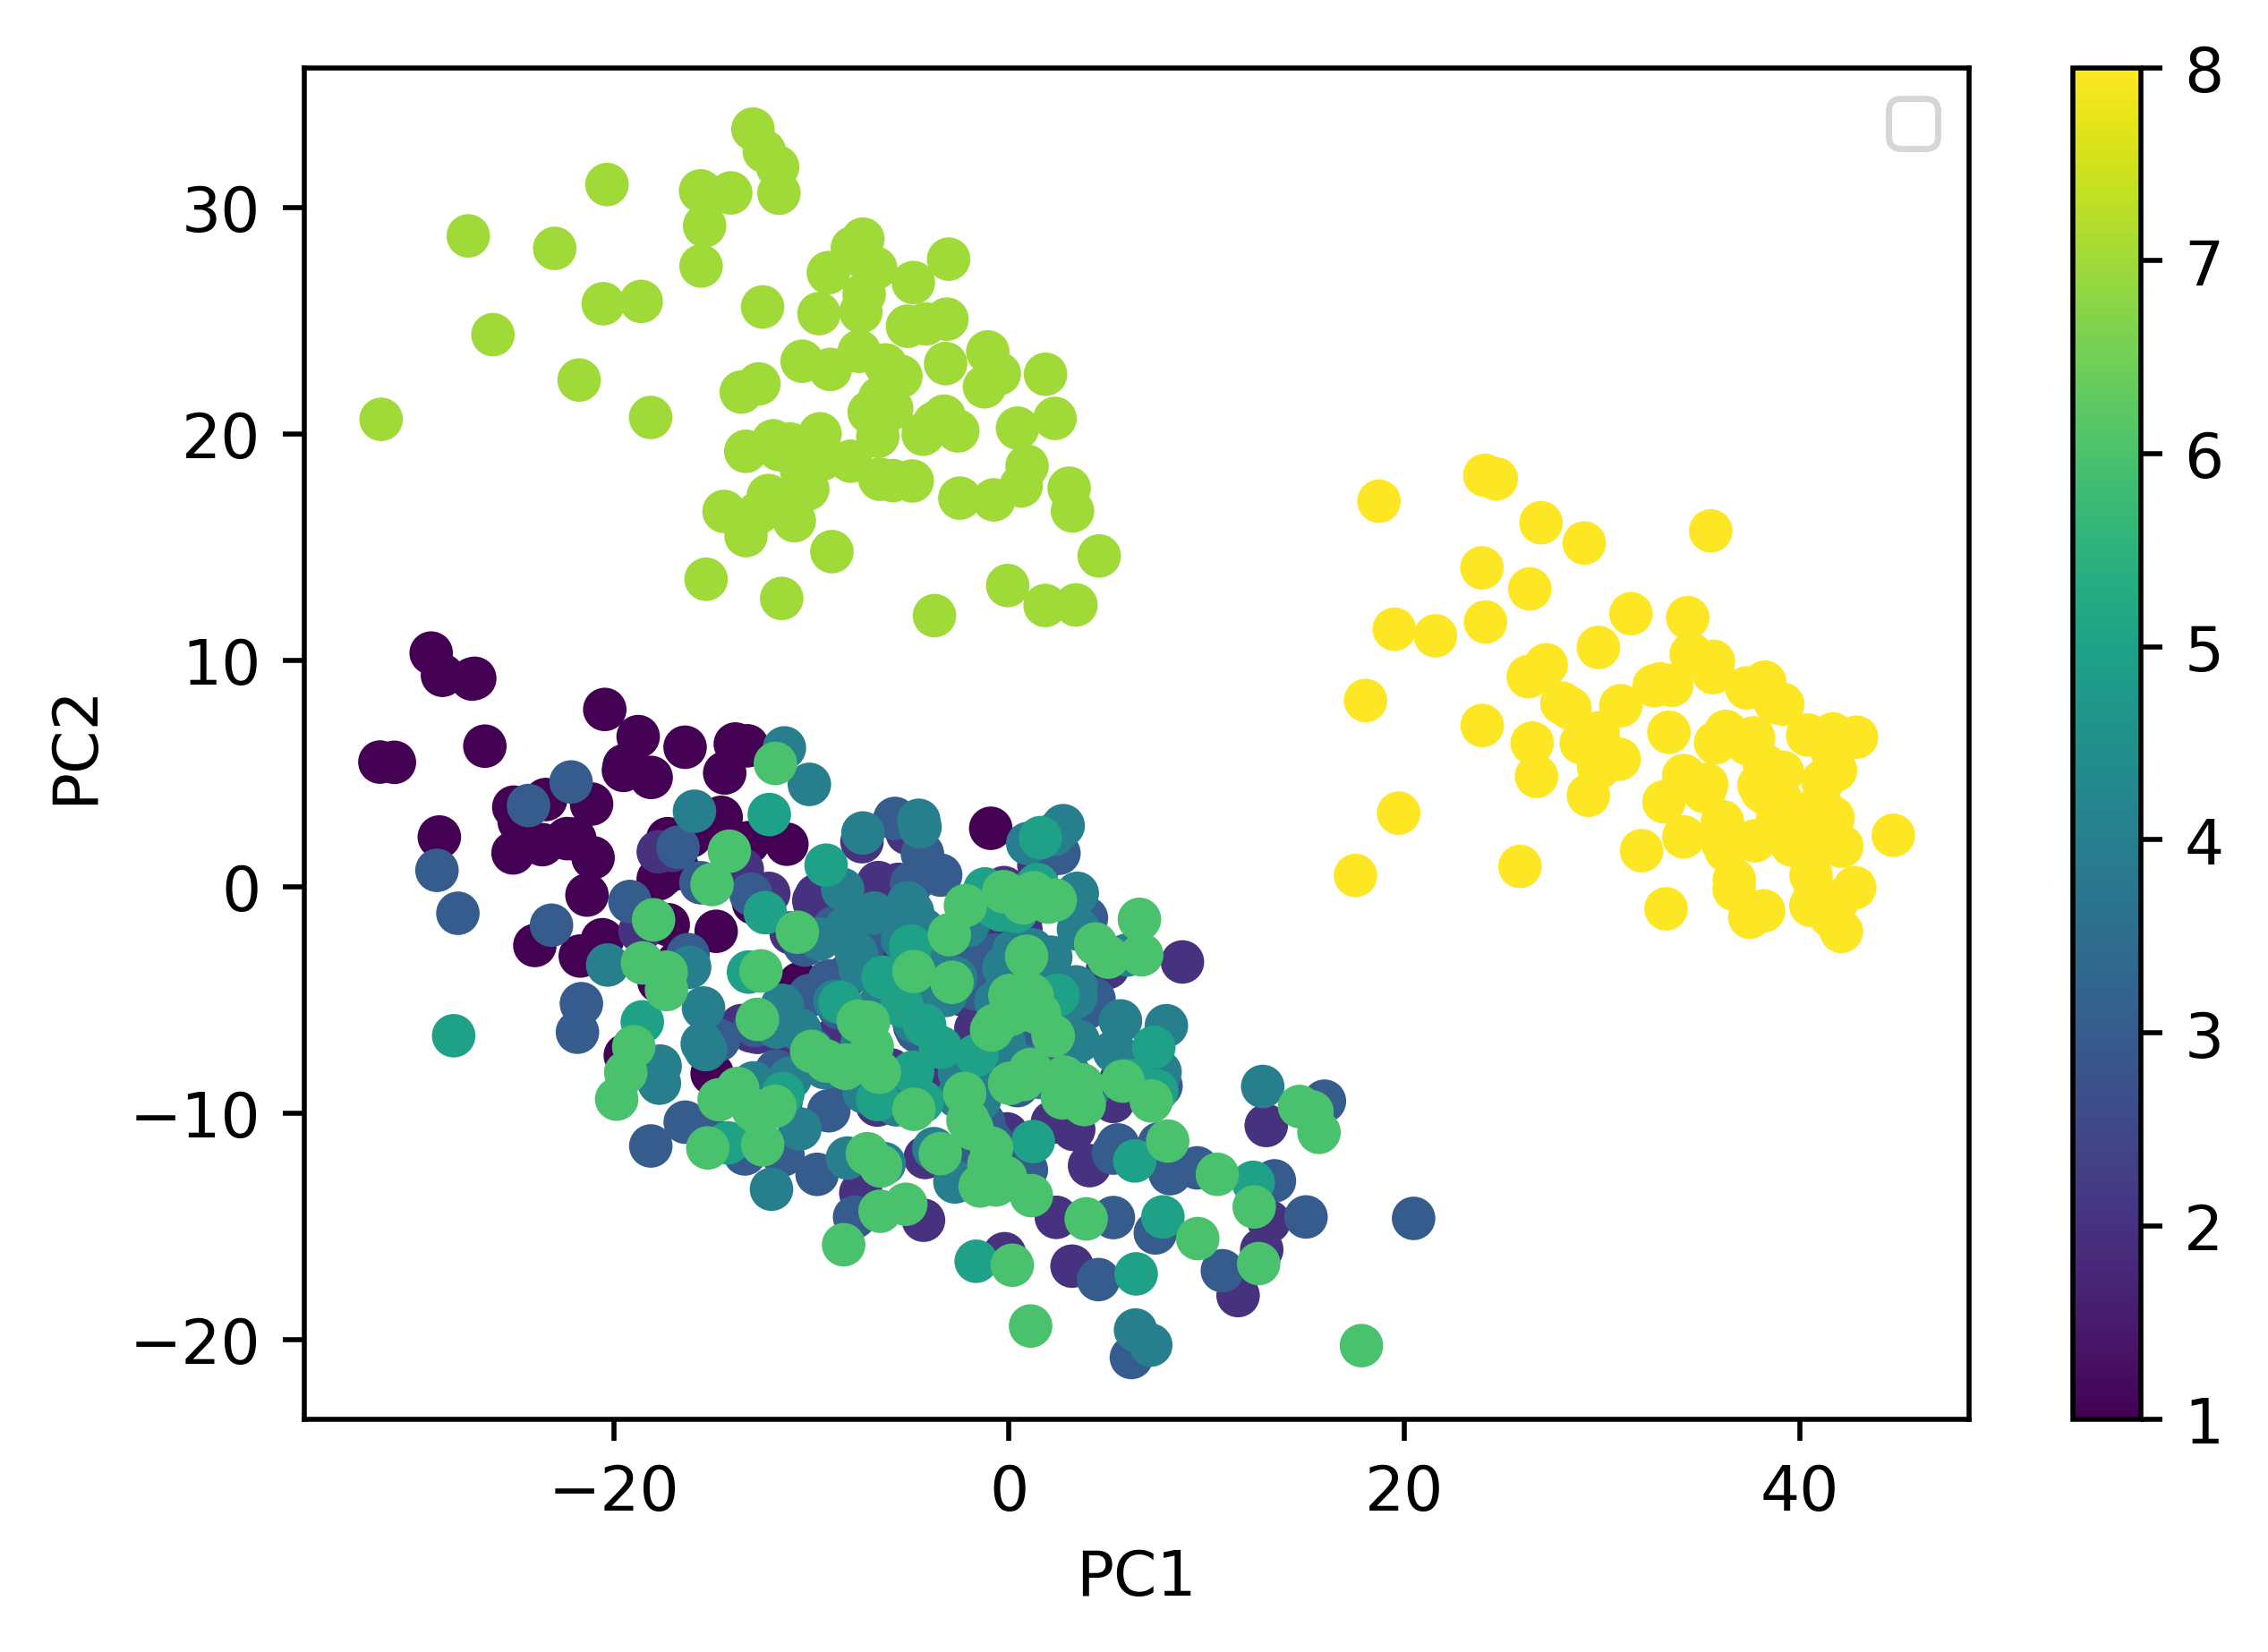

In [3]:
#visualize complete dataset

#first impute dataset
d_whole = areaData
d_whole_imput = helper.imputeRowMin(d_whole)

#log2 normalize
d_whole_imput = np.log2(d_whole_imput) 

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_imput)
loads = pca.transform(d_whole_imput)

#make pca plot by batch
plt.figure()
batch_con = batchInfo
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")


found 8 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
No handles with labels found to put in legend.


Adjusting data


Text(0, 0.5, 'PC2')

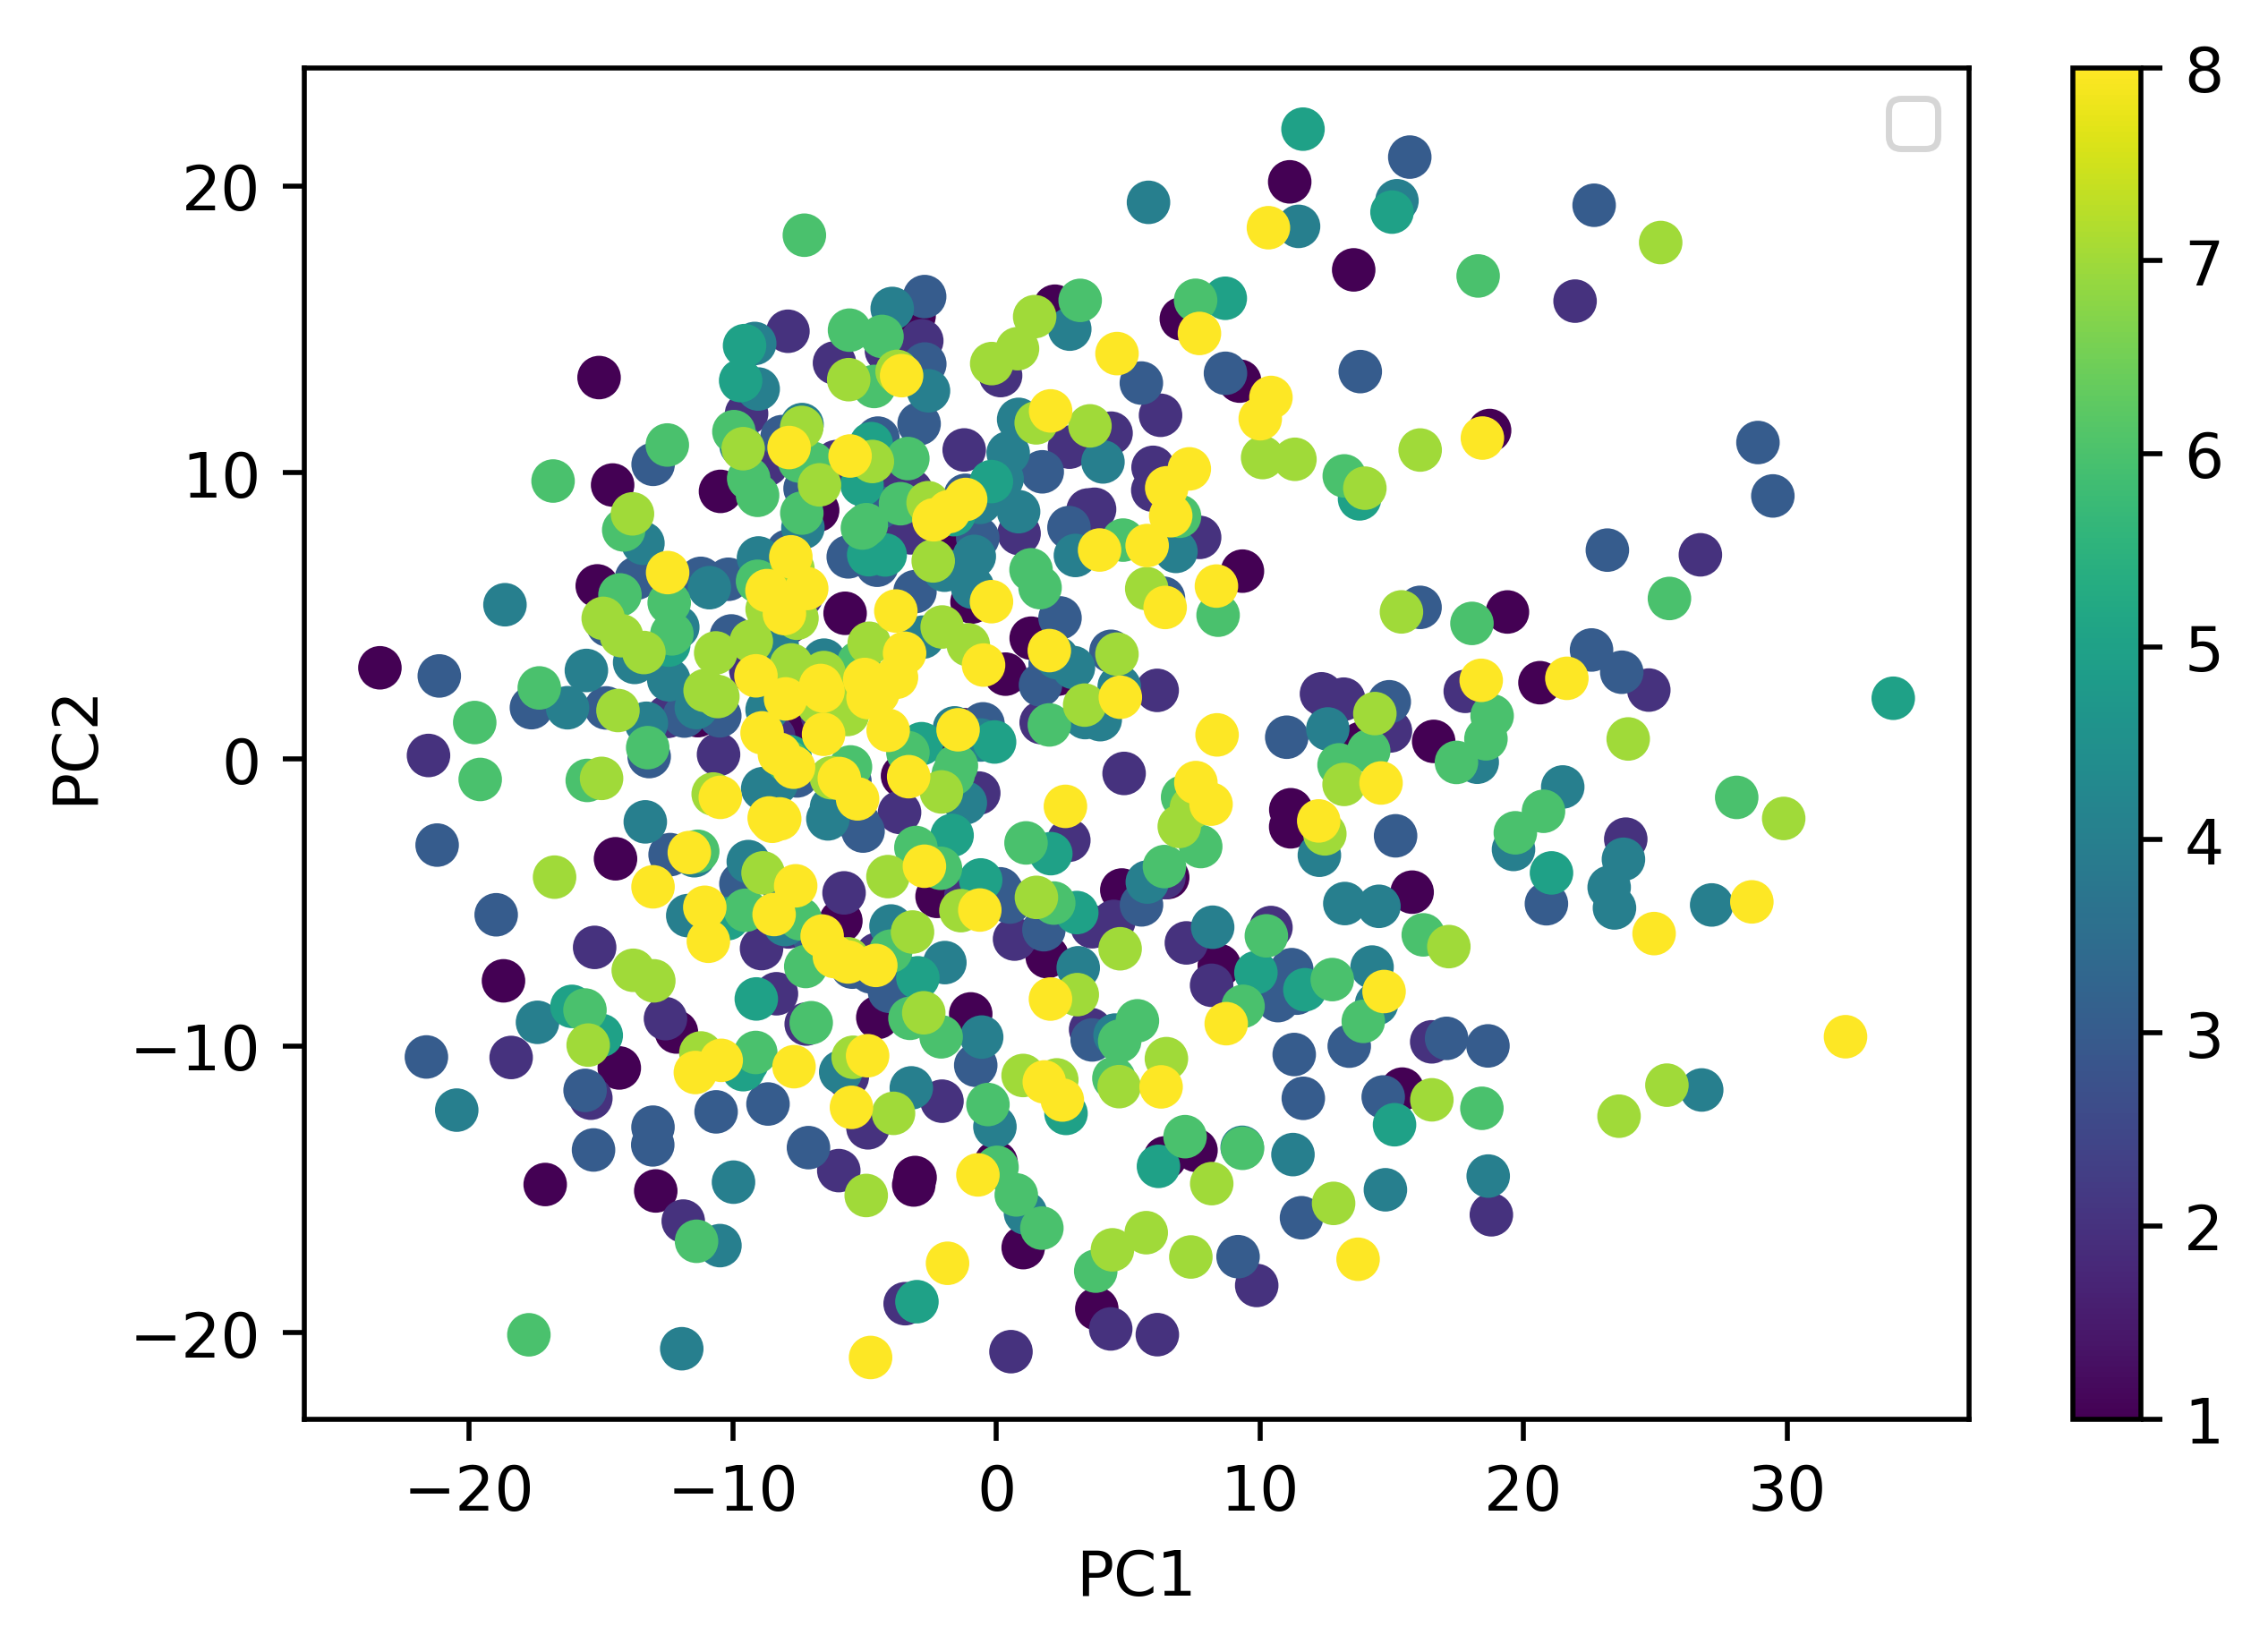

In [4]:
#now quantile normalize

d_whole_norm = combat.combat(pd.DataFrame(d_whole_imput.transpose()),batchInfo).transpose().to_numpy()

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

#make pca plot by batch
plt.figure()
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")



In [5]:
data = data[list(data.columns.values[:5]) + areaCols]
for x in data.columns.values[:5]:
    sampleNameDict[x] = x
data[areaCols] = np.power(2,d_whole_norm.transpose())
data = data.rename(axis=1,mapper=sampleNameDict)
data.to_csv(datafilename.replace(".csv","_generalSampleName_WU350_normalized.csv"))

In [6]:
print(data)

                           Molecule Name Molecule Formula  Precursor Charge  \
0    1_(Z)-3-Hydroxyoctadec-7-enoic acid         C18H34O3                -1   
1               2_1 5 Anhydro D glucitol          C6H12O5                -1   
2                    3_1 Methyluric acid         C6H6N4O3                -1   
3     4_1_4-Cyclohexanedicarboxylic acid          C8H12O4                -1   
4                 5_14 Z Eicosenoic acid         C20H38O2                -1   
..                                   ...              ...               ...   
229                          238_Skatole            C9H9N                 1   
230                          239_Taurine         C2H7NO3S                 1   
231                        240_Terbucarb        C17H27NO2                 1   
232                     241_Theophylline         C7H8N4O2                 1   
233       242_trans 3 Indoleacrylic acid         C11H9NO2                 1   

     Precursor Mz  Explicit Retention Time  B1_WU35

In [7]:
#write normalized data
